# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
import ffmpeg
import viewer

First we create the environment:

In [2]:
env = gym.make('CartPole-v0') # Create environment

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [3]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.01193603  0.01508122 -0.0485713  -0.02901684]
sample action: 0


**Note:** you will likely not be able to render environments in a Google Colab instance. Therefore, it may be beneficial for you to run this week's notebooks locally and/or team up with another student if you do not have a local environment.

The function below is used for display:

In [4]:
def show_replay():
    """
    Not-so-elegant way to display the MP4 file generated by the Monitor wrapper inside a notebook.
    The Monitor wrapper dumps the replay to a local file that we then display as a HTML video object.
    """
    import io
    import base64
    from IPython.display import HTML
    video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [5]:
env = gym.make('CartPole-v0') # Create environment
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
show_replay()

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [21]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden1, n_hidden2, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden1 = nn.Linear(n_inputs, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [22]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [23]:
n_inputs = env.observation_space.shape[0]
n_hidden1 = 20
n_hidden2 = 10
n_outputs = env.action_space.n

print(n_inputs, n_hidden, n_outputs)
print('state shape:', n_inputs)
print('action shape:', n_outputs)

4 20 2
state shape: 4
action shape: 2


In [33]:
# training settings

num_episodes = 1500#800
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden1, n_hidden2, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # Variance Minimization:
        
        returns = (returns - returns.mean())/returns.std()
        
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  24.35, mean validation reward:  61.80, mean loss: -0.0054
 200. mean training reward:  31.77, mean validation reward:  75.00, mean loss: -0.0050
 300. mean training reward:  40.54, mean validation reward: 132.80, mean loss: -0.0051
 400. mean training reward:  49.63, mean validation reward:  68.20, mean loss: -0.0013
 500. mean training reward:  76.95, mean validation reward: 192.60, mean loss: -0.0206
 600. mean training reward: 154.10, mean validation reward: 200.00, mean loss: -0.0115
 700. mean training reward: 168.15, mean validation reward: 197.20, mean loss: -0.0138
 800. mean training reward: 186.27, mean validation reward: 200.00, mean loss: -0.0045
 900. mean training reward: 181.29, mean validation reward: 185.60, mean loss: -0.0044
1000. mean training reward: 174.08, mean validation reward: 200.00, mean loss: -0.0039
1100. mean training reward: 197.36, mean validation reward: 200.00, mean loss: -0.0019
1200. mean training reward: 

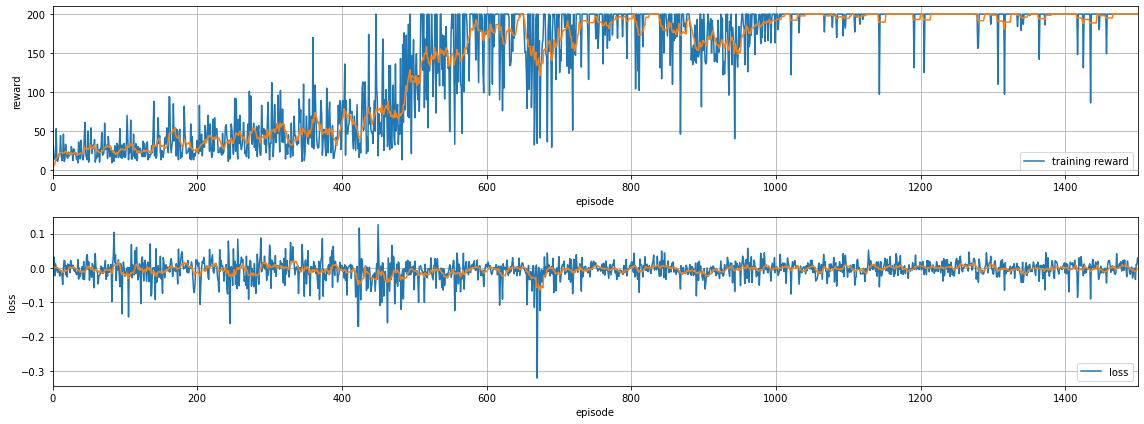

In [34]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [32]:
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
env.close()
show_replay()

## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

- Without reducing variance, loss increases as the rewards increases with the number of episodes.
- If we don't change anything (including variance reducing) in the model, and just increase the number of episodes, mean validation reward reaches to 200 but again mean loss increases.
- After reducing variance while applying the formula above, loss mean has been minimized drastically. It reached to 200 mean validation reward after a little bit later than the one at which variance wasn't reduced. Mean training reward is not as good as mean validation reward which really caught my attention.
- After adding one more hidden layer as an extra network layer, mean validation reward hit to 200, 100 number of episodes eaerlier. But most important point is that, mean training reward was around 200 now. 
- When learning rate has increased, of course it learned faster but there is the classical dilemma we have that after learning, mean validation loss oscillates more and shows an unstable graph which we don't want. For example after 1000 iterations, mean validation loss drops suddenly and then fixes itself.
-  When the discount factor is reduced, I've seen the network also works around ~0.90 discount values as well. But the less I trusted in it got a little bit worse, therefore I decided to keep it at 1.0.


### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

- 2.1: The total reward equation is as follows;
$$
R_t = r_t + r_{t+1} + r_{t+2} + \dots + r_T = \sum_{k=0}^{T-t} r_{t+k} 
$$
and thus 
$$
R_9 = 5
$$
- 2.2: For each timestep we will have;

$$
R_0 = (0 + 1 + 1 + 1 + 0 + 1 + 1 + 0 + 0 + 0) = 5, \\
R_1 = (1 + 1 + 1 + 0 + 1 + 1 + 0 + 0 + 0) = 5, \\ 
R_2 = (1 + 1 + 0 + 1 + 1 + 0 + 0 + 0) = 4, \\
R_3 = (1 + 0 + 1 + 1 + 0 + 0 + 0) = 3, \\
R_4 = (0 + 1 + 1 + 0 + 0 + 0) = 2, \\
R_5 = (1 + 1 + 0 + 0 + 0) = 2, \\
R_6 = (1 + 0 + 0 + 0) = 1, \\
R_7 = (0 + 0 + 0) = 0, \\
R_8 = (0 + 0) = 0, \\
R_9 = 0. \\
$$
- 2.3: The discounted future reward equation is as follows;
$$
R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T} r_T = \sum_{k=0}^{T-t} \gamma^k r_{t+k}
$$
For $ \gamma = 0.9 $ and for each timestep we have
$$
R_0 = (0+ 1*0.9 + 1*0.9^2 + 1*0.9^3 + 0*0.9^4 + 1*0.9^5 + 1*0.9^6 + 0 + 0 + 0) = 3.56, \\ 
R_1 = (1 + 1*0.9 + 1*0.9^2 + 0*0.9^3 + 1*0.9^4 + 1*0.9^5 + 0 + 0 + 0) = 3.95 \\
R_2 = (1 + 1*0.9 + 0*0.9^2 + 1*0.9^3 + 1*0.9^4 + 0 + 0 + 0) = 3.28, \\
R_3 = (1 + 0*0.9 + 1*0.9^2 + 1*0.9^3 + 0 + 0 + 0) = 2.53, \\
R_4 = (0 + 1*0.9 + 1*0.9^2 + 0 + 0 + 0) = 1.71,\\
R_5 = (1 + 1*0.9 + 0 + 0 + 0) = 1.9\\
R_6 = (1 + 0 + 0 + 0) = 1, \\
R_7 = (0 + 0 + 0) = 0, \\
R_8 = (0 + 0) = 0, \\
R_9 = 0.  \\
$$
### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

In the very begining of the training, results are much worse than the later steps because only the samples with maximum probability are taken into account and used to obtain rewards for the validation rewards, on the other hand, for the training rewards; random samples from $a_{prob}$ distribution are taken and training rewards are appended together as the training process goes on. While training continues, we see that, training and validaiton rewards becomes more similiar scores.


### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

Exploration-exploitation dilemma will address the tradeoff between deterministic and stochastic approach. This approach also affects the policy gradient approach. Because a deterministic policy requires a model-based formulation when used for likelihood ratio policy gradients, on the other hand, a stochastic policy tries new actions while a deterministic policy requires the perturbation of policy parameters or sufficient stochasticity in the system which would affect the optimal solution. In our case it is the stochastic approach. 

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*


### Book exercise: 
One gotcha with the cross-entropy is that it can be difficult at first to remember the respective roles of the ys and the as. It's easy to get confused about whether the right form is $ -[y\ln a + (1-y)\ln (1-a)]$ or $-[a\ln y + (1-a)\ln (1-y)]$. What happens to the second of these expressions when $y=0$ or 1? Does this problem afflict the first expression? Why or why not?

**Answer:**

The cross-entropy cost function;
$$
-[y \ln a + (1-y) \ln (1-a)]
$$
A similar expression;
$$
-[a \ln y + (1-a) \ln (1-y)]
$$
but it cannot be defined when $y = 0$ or $ y = 1 $ since $\ln(x)$ when $x=0$ cannot be defined.

There are cases that we have have $y = 0$ or $y = 1$ since $y$ is the output.
$$
a = \sigma(z)
$$
and according to the definition of the sigmoid function
$$
0 < \sigma(z) < 1 
$$ 
for every $z$.